<a href="https://colab.research.google.com/github/Abrazacs/course_work_ml/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_ML_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_SI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %load_ext cuml.accel

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

In [ ]:
si_upper_border = 34.25
сс50_upper_border = 2079.43
ic50_upper_border = 1550

df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx')
df.dropna(inplace=True)
df = df[df['IC50, mM']<=ic50_upper_border] # убираем записи с выбросами по IC50
df = df[df['CC50, mM']<=сс50_upper_border] # убираем записи с выбросами по CC50
df.drop(['Unnamed: 0'], axis=1, inplace=True) # убираем индекс
df.drop(['CC50, mM', 'IC50, mM'], axis=1, inplace=True) # удаляем таргеты других задач
df = df[df['SI']<=si_upper_border] # убираем выбросы

df.head()

,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,28.125,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,...,0,0,0,0,0,0,0,0,3,0
1,7.000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,...,0,0,0,0,0,0,0,0,3,0
2,0.720,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,...,0,0,0,0,0,0,0,0,3,0
4,1.300,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,...,0,0,0,0,0,0,0,0,0,0
5,2.000,5.758408,5.758408,0.278083,0.278083,0.711012,28.600000,332.491,304.267,332.225249,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# создаем датафрейм для хранения результатов
resulst_df = pd.DataFrame(columns=['model_name', 'params', 'train_mse', 'test_mse', 'test_r2', 'test_mae'])

def add_result(model_name, params, train_mse, test_mse, test_r2, test_mae):

  """
  Функция для добавления результатов в датафрейм
  """
  global resulst_df
  new_row = {'model_name': model_name, 'params': params, 'train_mse': -train_mse, 'test_mse': test_mse, 'test_r2': test_r2, 'test_mae': test_mae}
  resulst_df = pd.concat([resulst_df, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
# создаем словарь моделей
models_config = {
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [3, 4, 5],
            'max_features': ['sqrt', 0.3, 0.5, 0.7]
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.1, 0.2, 0.3],
            'loss': ['linear', 'square', 'exponential'],
            'estimator': [
                DecisionTreeRegressor(max_depth=1),
                DecisionTreeRegressor(max_depth=2),
                DecisionTreeRegressor(max_depth=3)
            ]
        }
    }
}

In [ ]:
X = df.drop(['SI'], axis=1)
y = df['SI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def train_models_and_print_results(models_config, X_train, y_train, X_test, y_test, model_name_postfix=''):

  """
  Функция для обучения моделей и вывода результатов
  """

  for model_name, model_config in models_config.items():

    grid_search = GridSearchCV(estimator= model_config['model'],
                               param_grid=model_config['params'],
                               cv=5,
                               scoring='neg_mean_squared_error')

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    model_name = model_name + model_name_postfix

    add_result(model_name,
               grid_search.best_params_,
               grid_search.best_score_,
               mse,
               r2,
               mae)

    print(f'====================== {model_name} ===========================')
    print(f'Best params: {grid_search.best_params_}')
    print(f'Train MSE: {-grid_search.best_score_}')
    print(f'Test MSE: {mse}')
    print(f'Test R2: {r2}')
    print(f'Test MAE: {mae}')
    print('================================================================\n')

# Без стандартизации

In [ ]:
train_models_and_print_results(models_config, X_train, y_train, X_test, y_test)

====================== KNN ===========================
Best params: {'algorithm': 'auto', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
Train MSE: 65.15091285130059
Test MSE: 68.50493714453927
Test R2: -0.01647236723690515
Test MAE: 6.168323362222157

====================== RandomForest ===========================
Best params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50}
Train MSE: 57.373021706281634
Test MSE: 68.75500878281242
Test R2: -0.020182916005061724
Test MAE: 6.029737243426497

====================== AdaBoost ===========================
Best params: {'estimator': DecisionTreeRegressor(max_depth=3), 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}
Train MSE: 58.60006654744478
Test MSE: 66.48872651123916
Test R2: 0.01344405164768836
Test MAE: 6.302135557440739



# Добавляем стандартизацию

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_models_and_print_results(models_config, X_train_scaled, y_train, X_test_scaled, y_test, ' + StandardScaler')

====================== KNN + StandardScaler ===========================
Best params: {'algorithm': 'kd_tree', 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
Train MSE: 59.98530088765913
Test MSE: 66.2245302061089
Test R2: 0.017364181420589264
Test MAE: 6.0620268882156525

====================== RandomForest + StandardScaler ===========================
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Train MSE: 57.430045575353844
Test MSE: 66.77161805587924
Test R2: 0.009246522972566673
Test MAE: 5.939303959918608

====================== AdaBoost + StandardScaler ===========================
Best params: {'estimator': DecisionTreeRegressor(max_depth=3), 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}
Train MSE: 58.62787879740059
Test MSE: 67.3554429152682
Test R2: 0.000583762861967152
Test MAE: 6.272578662297057



# Используем FeatureSelection + StandardScaler

In [ ]:
feature_selection = SelectKBest(score_func=mutual_info_regression, k=15)

X_train_selected = feature_selection.fit_transform(X_train_scaled, y_train)
X_test_selected = feature_selection.transform(X_test_scaled)

train_models_and_print_results(models_config, X_train_selected, y_train, X_test_selected, y_test, ' + StandardScaler + SelectKbest')

====================== KNN + StandardScaler + SelectKbest ===========================
Best params: {'algorithm': 'brute', 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
Train MSE: 57.81094157131192
Test MSE: 71.54523171832533
Test R2: -0.061584085476911854
Test MAE: 6.212950176519802

====================== RandomForest + StandardScaler + SelectKbest ===========================
Best params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
Train MSE: 57.04222226125953
Test MSE: 67.23435255543161
Test R2: 0.0023804947449985736
Test MAE: 5.92000767289609

====================== AdaBoost + StandardScaler + SelectKbest ===========================
Best params: {'estimator': DecisionTreeRegressor(max_depth=3), 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}
Train MSE: 58.90162998965367
Test MSE: 67.92282912981236
Test R2: -0.00783508156990842
Test MAE: 6.483117825554054



# kernelPCA

In [ ]:
# Подбираем параметры для kernelPCA
kernel_pca_grid = {
    'kpca__kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
    'kpca__gamma': [0.001, 0.01, 0.1],
    'kpca__n_components': [10, 20, 30, 50],
    'knn__n_neighbors': [3, 5, 7]
}

pipe_kpca_knn = Pipeline([
    ('kpca', KernelPCA(fit_inverse_transform=False)),
    ('knn', KNeighborsRegressor())
])

grid_kpca_knn = GridSearchCV(pipe_kpca_knn, kernel_pca_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_kpca_knn.fit(X_train, y_train)

best_kpca_params = {k.replace('kpca__', ''): v for k, v in grid_kpca_knn.best_params_.items() if k.startswith('kpca')}

print(f"Лучшие параметры для kernelPCA на основе KNN: {best_kpca_params}")
print(f'======================================================================')

Лучшие параметры для kernelPCA на основе KNN: {'gamma': 0.001, 'kernel': 'sigmoid', 'n_components': 10}


In [ ]:
best_kpca = KernelPCA(**best_kpca_params)
X_train_kpca = best_kpca.fit_transform(X_train_scaled)
X_test_kpca = best_kpca.transform(X_test_scaled)

train_models_and_print_results(models_config, X_train_kpca, y_train, X_test_kpca, y_test, ' + StandardScaler + kernelPCA')

====================== KNN + StandardScaler + kernelPCA ===========================
Best params: {'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
Train MSE: 59.22312160960428
Test MSE: 70.16869231931783
Test R2: -0.041159072042452394
Test MAE: 6.06964485964945

====================== RandomForest + StandardScaler + kernelPCA ===========================
Best params: {'max_depth': 20, 'max_features': 0.3, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50}
Train MSE: 57.564407327250805
Test MSE: 69.01643806300301
Test R2: -0.02406198881903565
Test MAE: 6.101058496571124

====================== AdaBoost + StandardScaler + kernelPCA ===========================
Best params: {'estimator': DecisionTreeRegressor(max_depth=3), 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}
Train MSE: 60.46979371382709
Test MSE: 68.33230874436472
Test R2: -0.013910916837972298
Test MAE: 6.451785391832107



# Итоги

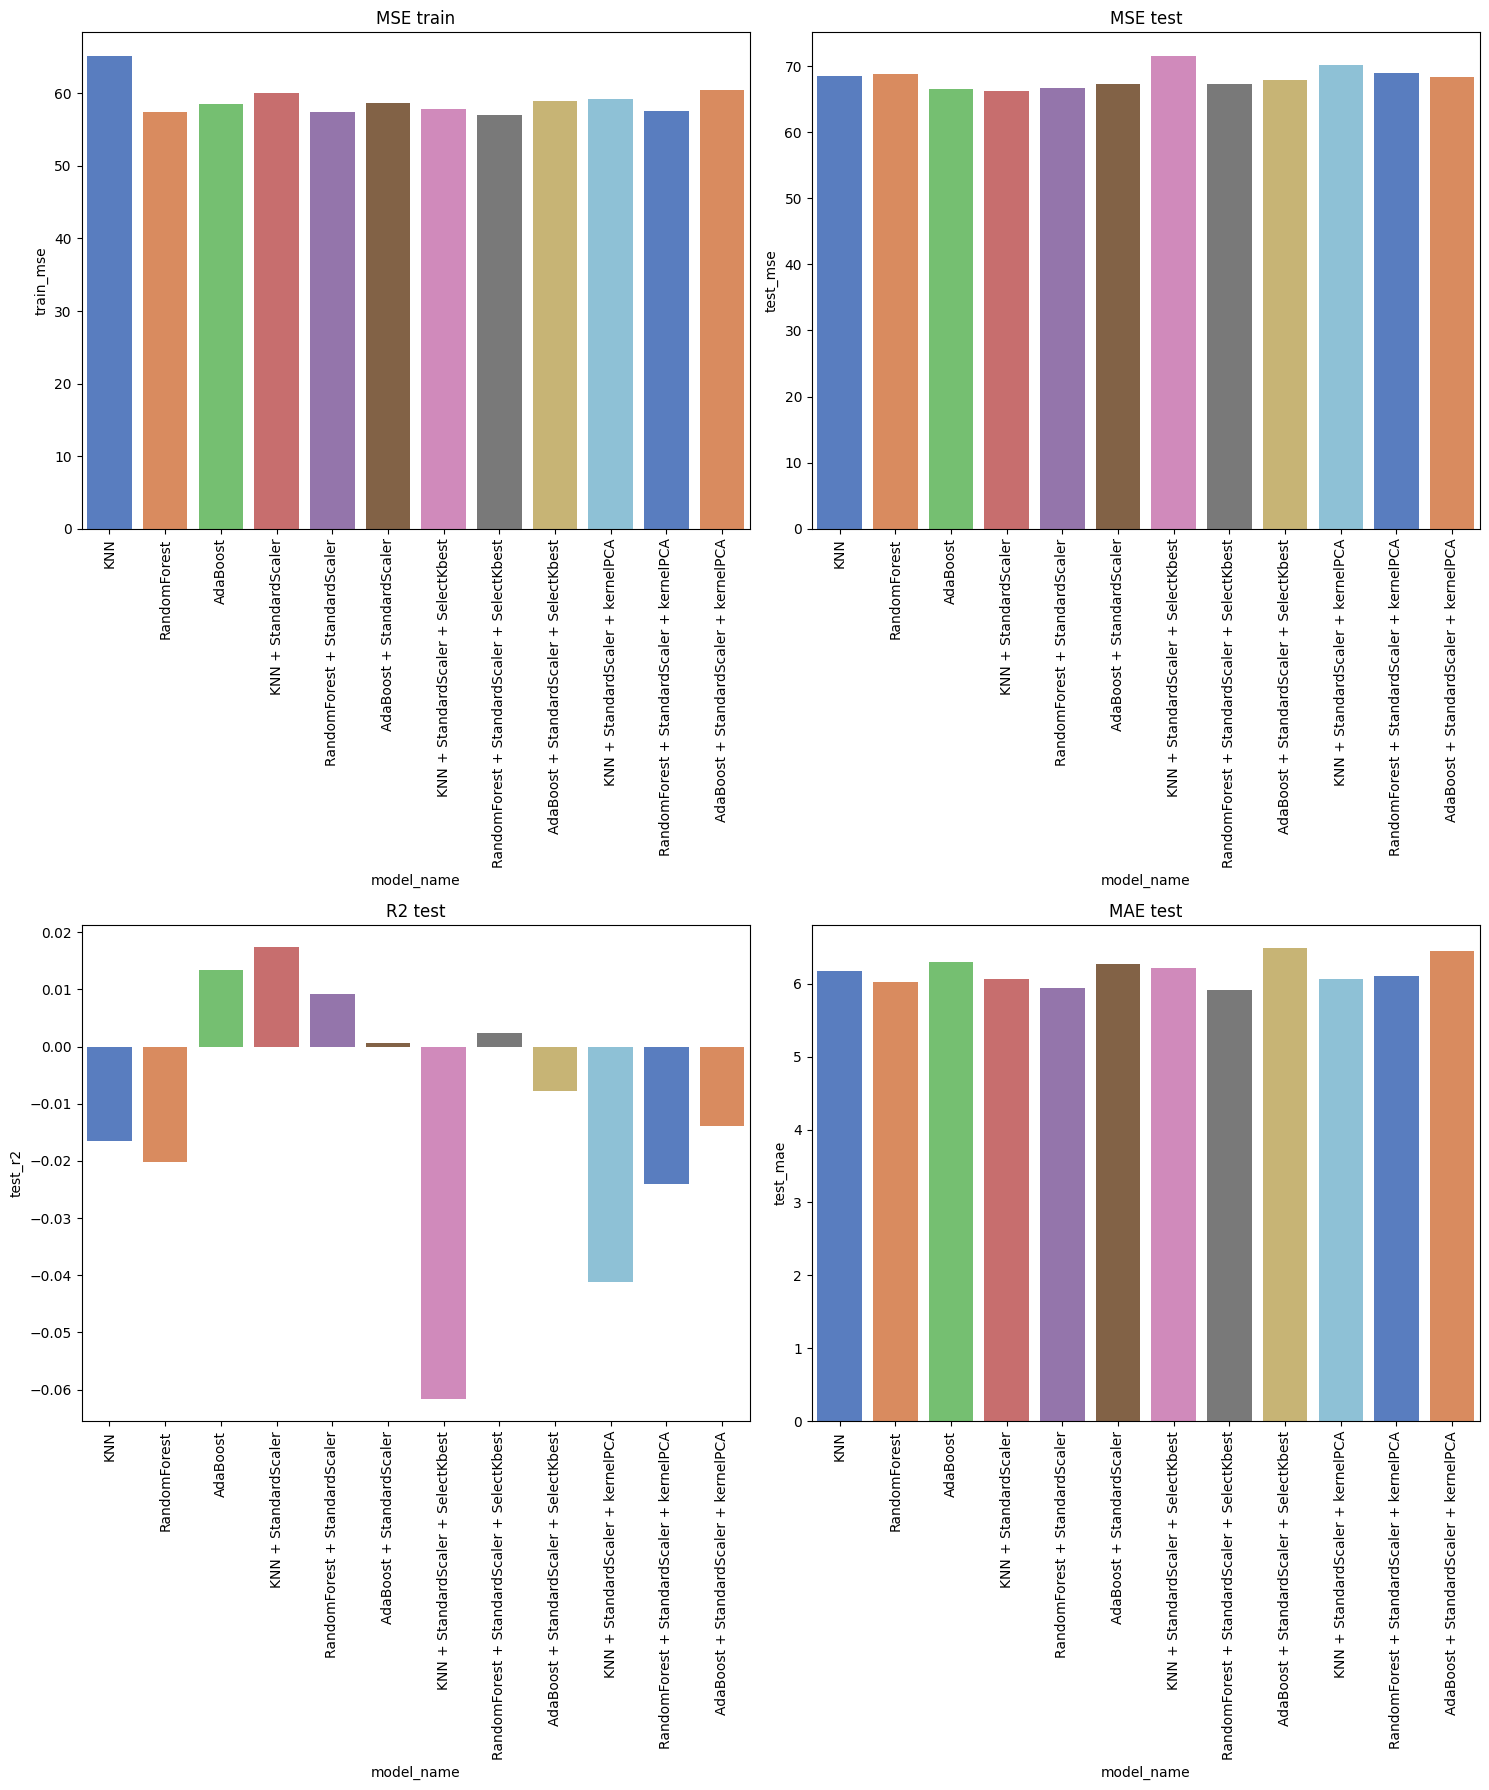

In [ ]:
x_column = 'model_name'
y_column_name_map = {
    'MSE train': 'train_mse',
    'MSE test': 'test_mse',
    'R2 test': 'test_r2',
    'MAE test': 'test_mae'
}

def draw_comparing_score_barplot(x, y_col, title, i_idx, j_idx, df, axes):
  sns.barplot(x=x, y=y_col, data=df, ax=axes[i_idx, j_idx], palette='muted')
  axes[i_idx, j_idx].set_title(title)
  axes[i_idx, j_idx].tick_params(axis='x', rotation=90)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 18))

for idx, (title, y_col) in enumerate(y_column_name_map.items()):
  i_idx = idx // 2
  j_idx = idx % 2
  draw_comparing_score_barplot(x_column, y_col, title, i_idx, j_idx, resulst_df, axes)

plt.tight_layout()
plt.show()